In [10]:
## Parameters for NS with polytropic EOS // TODO switch to take M1 M2 K Gam as input
Gam_EOS = 2.0     # polytropic index Gamma  P = K * rho^Gamma
K_EOS = 100       # polytropic const K
rho_c = 1.28e-3   # central density

print("central density in SI units :",rho_c * 6.17595e17)


central density in SI units : 790521600000000.1


In [2]:
import numpy as np

m_sun     = 1.98847e33; #g
km        = 1.0e5;
ggrav     = 6.67408e-8;
clight    = 2.99792e10;
Rsch_sun  = ggrav*m_sun/clight**2;

PI = np.pi;

class TOV:
    def __init__(self, K_EOS, Gam_EOS, rho_c):
        self.K_EOS = K_EOS
        self.Gam_EOS = Gam_EOS
        self.rho_c = rho_c
        self.n_EOS = 1/(self.Gam_EOS - 1)
        
        self.M_star  = 0  # Gravitational mass
        self.R_star  = 0  # Radius
        self.Mb_star = 0  # Baryonic mass
        self.log_enth = 0 # log(enthalpy)
        
    # rho is the rest mass
    def P_EOS(self, rho):
        return self.K_EOS * pow(rho, self.Gam_EOS)
    
    def eps_EOS(self, rho): 
        return self.K_EOS * pow(rho, self.Gam_EOS-1) / (self.Gam_EOS-1)
    
    def dPdrho_EOS(self, rho):
        return self.K_EOS * pow(rho, self.Gam_EOS-1) * self.Gam_EOS
    
    def rho_EOS(self, P):
        return pow(P/self.K_EOS, 1.0/self.Gam_EOS)
    
    
    # derivative functions
    # s  = r^2
    # m  = gravitational mass
    # mb = baryonic mass
    def d_arr (self, th, arr):
        s,m, mb = arr[0], arr[1], arr[2]
        
        r = np.sqrt(s)
        rho = self.rho_c * th**self.n_EOS
        
        P      = self.P_EOS(rho)
        dPdrho = self.dPdrho_EOS(rho)
        eps    = self.eps_EOS(rho)
        
        ds_dth  = -2*self.n_EOS/m/th*r*r*r*dPdrho*(1-2*m/r)/((1+eps)+P/rho)/(1+4*PI*r*r*r*P/m)
        dm_dth  = 2*PI*r*rho*ds_dth*(1+eps)
        dmb_dth = 2*PI*r*rho*ds_dth/(1-2*m/r)**0.5
        return np.array([ds_dth, dm_dth, dmb_dth])
    
    # Runge-Kutta 4-th order method
    def RK4(self, x, arr, dx):
        k1 = self.d_arr(x     , arr          )
        k2 = self.d_arr(x+dx/2, arr + k1*dx/2)
        k3 = self.d_arr(x+dx/2, arr + k2*dx/2)
        k4 = self.d_arr(x+dx  , arr + k3*dx  )
        arr_new = arr + (k1 + 2*k2 + 2*k3 + k4)*dx/6
        return arr_new
    
    # main iterative methods for TOV solver
    def solve_TOV_th(self, step):
        rho_c = self.rho_c
        
        P_c       = self.P_EOS(rho_c)
        eps_c     = self.eps_EOS(rho_c)
        dPdrho_c  = self.dPdrho_EOS(rho_c)
        
        self.log_enth = np.log(1+eps_c+P_c/rho_c)
        
        # integrated array theta
        # theta goes from [1,0] from core to surface
        # avoid singularity on the surface choose 1e-10**1/n as last step
        th_arr = np.linspace(1.0,(1e-10)**(1/self.n_EOS),step,endpoint = False)
        
        d_th = th_arr[1] - th_arr[0]
        
        s_arr  = np.zeros_like(th_arr)
        m_arr  = np.zeros_like(th_arr)
        mb_arr = np.zeros_like(th_arr)
        
        rho_tot_c = rho_c *(1 + eps_c)
        
        m_r3 = 4*PI/3*(rho_tot_c)
        s = (-3*self.n_EOS/(2*PI*rho_tot_c) * dPdrho_c / ((1+eps_c+P_c/rho_c) * (1+3*P_c/rho_tot_c)))*d_th
        m = m_r3 * s**1.5
        mb = 4*PI/3*(rho_c)*s**1.5
        
        arr = np.array([s,m,mb])
        for i in range(step-1):
            arr = self.RK4(th_arr[i],arr,th_arr[i+1]-th_arr[i])
            
        
        self.R_star = arr[0]**0.5
        self.M_star = arr[1]
        self.Mb_star = arr[2]
        
        print("K={:f} Gam={:f} rho_c={:e} log_enth={:f}".format(self.K_EOS, self.Gam_EOS, self.rho_c, self.log_enth))
        R, M, Mb = self.R_star, self.M_star, self.Mb_star
        print("R  = {:<10f} = {:<10e} km".format(R , R*Rsch_sun/km))
        print("M  = {:<10f} = {:<10e} g ".format(M , M*m_sun      ))
        print("Mb = {:<10f} = {:<10e} g ".format(Mb, Mb*m_sun     ))
        print(R,M/1.476,Mb/1.476)
              
              

In [3]:
NS = TOV(123.641, 2, 6.235e14 / 6.17595e17)
NS.solve_TOV_th(10000)

K=123.641000 Gam=2.000000 rho_c=1.009561e-03 log_enth=0.222861
R  = 10.711552  = 1.581695e+01 km
M  = 1.543142   = 3.068491e+33 g 
Mb = 1.658456   = 3.297790e+33 g 
10.711552133687311 1.0454891003931768 1.123615269190021


In [22]:
rho_cgs = 5.7e15
rho_km = rho_cgs / 6.17595e17 / (1.476**2) 
print(rho_km)

NS = TOV(100, 2, rho_km)
NS.solve_TOV_th(10000)

0.004236413754155087
K=100.000000 Gam=2.000000 rho_c=4.236414e-03 log_enth=0.613716
R  = 7.019310   = 1.036489e+01 km
M  = 1.615156   = 3.211689e+33 g 
Mb = 1.768786   = 3.517177e+33 g 
7.0193099965963714 1.094279093041991 1.1983643440344602


### Star 1 ###
K=100.000000 Gam=2.000000 rho_c=1.280000e-03 log_enth=0.227932
R  = 9.584239   = 1.415233e+01 km
M  = 1.400209   = 2.784273e+33 g 
Mb = 1.506234   = 2.995102e+33 g 
9.58423937219602 0.9486508147972765 1.02048396589987

### Star 2 ###
K=100.000000 Gam=2.000000 rho_c=1.280000e-03 log_enth=0.227932
R  = 9.584239   = 1.415233e+01 km
M  = 1.400209   = 2.784273e+33 g 
Mb = 1.506234   = 2.995102e+33 g 
9.58423937219602 0.9486508147972765 1.02048396589987

### coalescence ###
Total mass = 2.800417e+00, mass ratio = 1.000000e+00
x1  = -15.237445 = -22.500000 km
x2  = 15.237445  = 22.500000  km


(-20.0, 20.0)

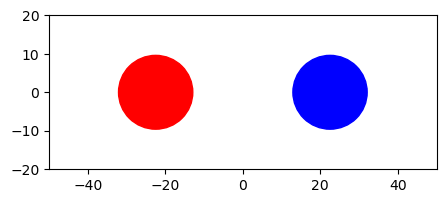

In [6]:
# parameters

rho_c_1 = 1.28e-3

rho_c_2 = 1.28e-3

sep_PNevo = 90 #km
sep_final = 45  #km

#########################

print("### Star 1 ###")
NS1 = TOV(K_EOS, Gam_EOS, rho_c_1)
NS1.solve_TOV_th(10000)

print("")

print("### Star 2 ###")
NS2 = TOV(K_EOS, Gam_EOS, rho_c_2)
NS2.solve_TOV_th(10000)

print("")

print("### coalescence ###")
M1 ,  M2 = NS1.M_star ,  NS2.M_star
R1 ,  R2 = NS1.R_star ,  NS2.R_star
Mb1, Mb2 = NS1.Mb_star,  NS2.Mb_star
M0, ratio = M1+M2, np.exp(np.abs(np.log(M1/M2)))
x1 = -sep_final * M2/M0
x2 = +sep_final * M1/M0

print("Total mass = {:<10e}, mass ratio = {:<10e}".format(M0, ratio))
print("x1  = {:<10f} = {:<10f} km".format(x1*km/Rsch_sun , x1)) # CarpetRegrid2::position_x_1
print("x2  = {:<10f} = {:<10f} km".format(x2*km/Rsch_sun , x2)) # CarpetRegrid2::position_x_2

import matplotlib.pyplot as plt

circle1 = plt.Circle((x1, 0),   R1, color='r')
circle2 = plt.Circle((x2, 0),   R2, color='blue')
fig, ax = plt.subplots(figsize=(5,2))
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.set_xlim(-50,50)
ax.set_ylim(-20,20)